In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

### Dataset

In [9]:
read_file = pd.read_csv (r'/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/household_power_consumption.txt')
read_file.to_csv (r'/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/household_power_consumption.csv', index=None)

In [19]:
filepath = '/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/household_power_consumption.csv'
#df = pd.read_csv(filepath, sep = ";",parse_dates=['Date'], index_col='Date')
#print(df.shape)  # (123, 8)
df = pd.read_csv(filepath, sep = ";")
df = df.loc[0: : 30] # 30 minutes
df = df.drop(labels=['Time','Date'], axis=1)
print(df.shape)
df.dropna(inplace = True)
df.tail()

/home/hugo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(69176, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075130,1.556,0.064,237.56,6.6,0.0,0.0,0.0
2075160,1.12,0.082,238.91,4.6,0.0,0.0,0.0
2075190,1.468,0.134,238.44,6.2,0.0,0.0,0.0
2075220,1.082,0.136,240.32,4.6,0.0,1.0,0.0
2075250,0.946,0.0,239.31,4.0,0.0,0.0,0.0


In [20]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'],errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'],errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'],errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'],errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'],errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'],errors='coerce')
df['Sub_metering_3'] = pd.to_numeric(df['Sub_metering_3'],errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68308 entries, 0 to 2075250
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    68308 non-null  float64
 1   Global_reactive_power  68308 non-null  float64
 2   Voltage                68308 non-null  float64
 3   Global_intensity       68308 non-null  float64
 4   Sub_metering_1         68308 non-null  float64
 5   Sub_metering_2         68308 non-null  float64
 6   Sub_metering_3         68308 non-null  float64
dtypes: float64(7)
memory usage: 4.2 MB


In [21]:
round(df.describe(),3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,68308.000,68308.000,68308.000,68308.000,68308.000,68308.000,68308.000
mean,1.092,0.124,240.853,4.629,1.132,1.293,6.459
std,1.059,0.113,3.219,4.451,6.211,5.785,8.428
min,0.078,0.000,225.320,0.200,0.000,0.000,0.000
25%,0.308,0.048,239.050,1.400,0.000,0.000,0.000
50%,0.600,0.100,241.030,2.600,0.000,0.000,1.000
75%,1.530,0.194,242.870,6.400,0.000,1.000,17.000
max,10.290,1.094,253.360,44.600,87.000,79.000,31.000


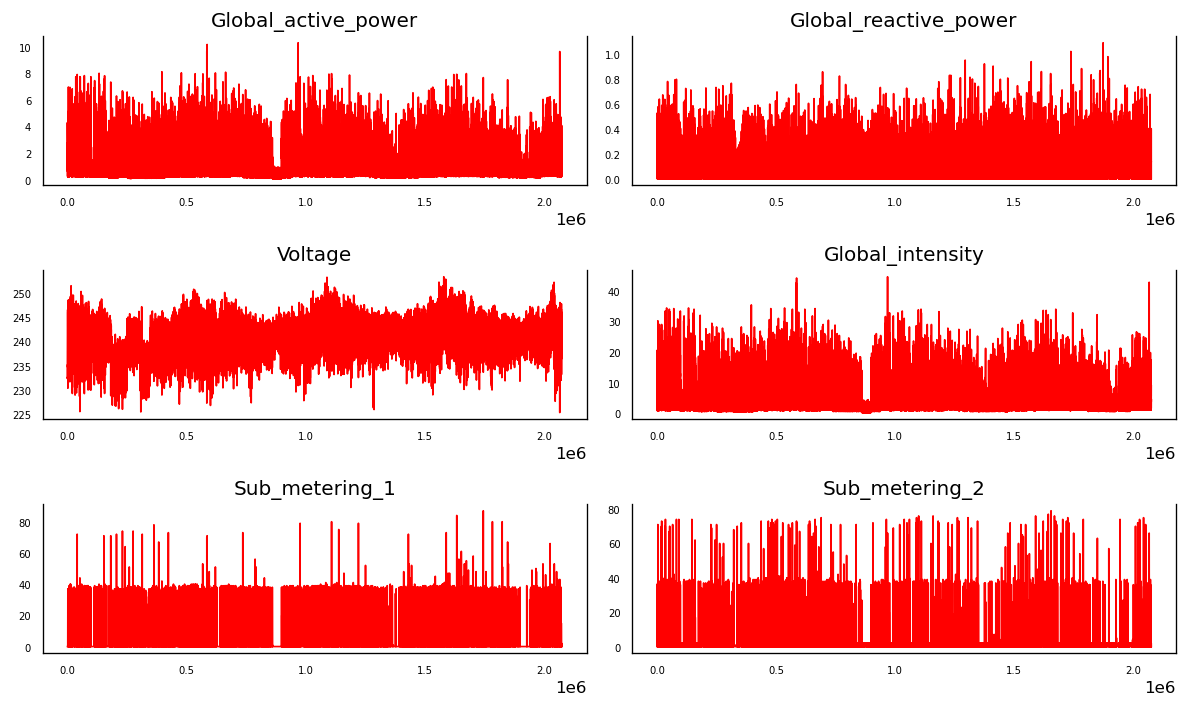

In [22]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Testing Causation using Granger’s Causality Test

In [7]:
# from statsmodels.tsa.stattools import grangercausalitytests
# maxlag=12
# test = 'ssr_chi2test'
# def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
#     """Check Granger Causality of all possible combinations of the Time series.
#     The rows are the response variable, columns are predictors. The values in the table 
#     are the P-Values. P-Values lesser than the significance level (0.05), implies 
#     the Null Hypothesis that the coefficients of the corresponding past values is 
#     zero, that is, the X does not cause Y can be rejected.

#     data      : pandas dataframe containing the time series variables
#     variables : list containing names of the time series variables.
#     """
#     df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in df.columns:
#         for r in df.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
#             p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             df.loc[r, c] = min_p_value
#     df.columns = [var + '_x' for var in variables]
#     df.index = [var + '_y' for var in variables]
#     return df

# grangers_matrix = grangers_causation_matrix(df, variables = df.columns)     

In [8]:
# grangers_matrix

In [10]:
# f, ax = plt.subplots(figsize=(25, 20))
# sns.heatmap(grangers_matrix, cmap='RdYlGn_r', annot=True,linewidths=.5)

### Cointegration Test

<AxesSubplot:>

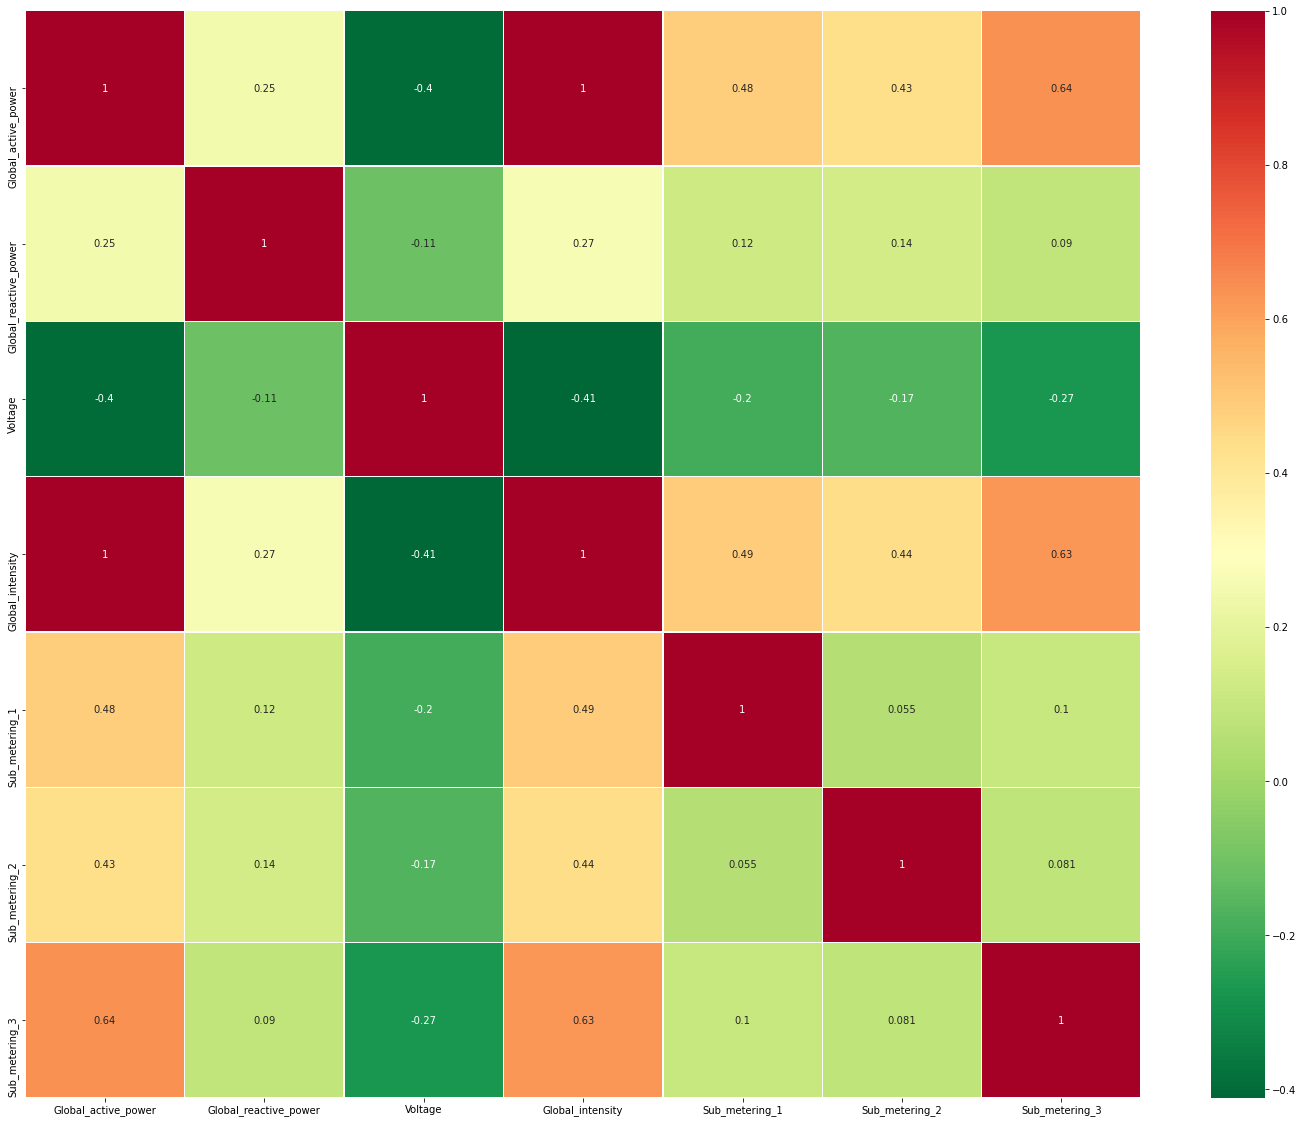

In [11]:
cov_data= df.corr()
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(cov_data, cmap='RdYlGn_r', annot=True,linewidths=.5)

In [12]:
cov_data= df.corr()
cov_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


In [13]:
# from statsmodels.tsa.vector_ar.vecm import coint_johansen

# def cointegration_test(df, alpha=0.05): 
#     """Perform Johanson's Cointegration Test and Report Summary"""
#     out = coint_johansen(df,-1,5)
#     d = {'0.90':0, '0.95':1, '0.99':2}
#     traces = out.lr1
#     cvts = out.cvt[:, d[str(1-alpha)]]
#     def adjust(val, length= 6): return str(val).ljust(length)

#     # Summary
#     print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
#     for col, trace, cvt in zip(df.columns, traces, cvts):
#         print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

# cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Global_active_power ::  305298.49 > 111.7797  =>   True
Global_reactive_power ::  216879.12 > 83.9383   =>   True
Voltage ::  136278.56 > 60.0627   =>   True
Global_intensity ::  77175.53  > 40.1749   =>   True
Sub_metering_1 ::  33607.22  > 24.2761   =>   True
Sub_metering_2 ::  12744.95  > 12.3212   =>   True
Sub_metering_3 ::  1.33      > 4.1296    =>   False


In [23]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [24]:
# ADF Test on each column
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Global_active_power" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.867
 No. Lags Chosen       = 54
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Global_reactive_power" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.9737
 No. Lags Chosen       = 58
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Voltage" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

In [25]:
df_differenced = df.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Global_active_power" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -64.4597
 No. Lags Chosen       = 52
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Global_reactive_power" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -53.1869
 No. Lags Chosen       = 61
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Voltage" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stati

### KPSS test

In [26]:
# regression='ct'
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, name='', **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Test on "{name}"', "\n   ", '-'*47)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


In [27]:
for name, column in df.iteritems():
    kpss_test(column, name=column.name)
    print('\n')

KPSS Test on "Global_active_power" 
    -----------------------------------------------
KPSS Statistic: 1.7806603511148855
p-value: 0.01
num lags: 62
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


KPSS Test on "Global_reactive_power" 
    -----------------------------------------------
KPSS Statistic: 4.36931296505137
p-value: 0.01
num lags: 62
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


KPSS Test on "Voltage" 
    -----------------------------------------------
KPSS Statistic: 18.853311697428374
p-value: 0.01
num lags: 62
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


KPSS Test on "Global_intensity" 
    -----------------------------------------------
KPSS Statistic: 2.00274885100895
p-value: 0.01
num lags: 62
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2041: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2072: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2072: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  war

In [28]:
df_differenced = df.diff().dropna()
for name, column in df_differenced.iteritems():
    kpss_test(column, name=column.name)
    print('\n')

KPSS Test on "Global_active_power" 
    -----------------------------------------------
KPSS Statistic: 0.0016671693365145077
p-value: 0.1
num lags: 62
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


KPSS Test on "Global_reactive_power" 
    -----------------------------------------------
KPSS Statistic: 0.0013580775543209024
p-value: 0.1
num lags: 62
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


KPSS Test on "Voltage" 
    -----------------------------------------------
KPSS Statistic: 0.0014360410950916655
p-value: 0.1
num lags: 62
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


KPSS Test on "Global_intensity" 
    -----------------------------------------------
KPSS Statistic: 0.0017810015555884625
p-value: 0.1
num lags: 62
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2041: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2076: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2076: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  war